In [ ]:
import os
def homePath(path):
    return os.path.join(os.path.expanduser("~"), path.strip("~/"))

#Model Creation 1
#Figure out how to do versioning effectively
individualInput = False
combinedInputPath = homePath("~/SPGenerations/")
pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"
GradesTokensName = ""


if not individualInput:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")

if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)





modelOutputPath = homePath("~/SPGenerations/Models")



In [2]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os



#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
print (combinedDF)







                                                tokenCode  \
0       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
1       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
2       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
3       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
4       [9, 2, 42, 435, 27, 632, 5, 759, 5, 660, 2, 27...   
...                                                   ...   
207082  [27, 685, 2, 42, 291, 27, 291, 2, 27, 840, 2, ...   
207083  [27, 685, 2, 42, 291, 27, 291, 2, 27, 840, 2, ...   
207084  [27, 685, 2, 42, 291, 27, 291, 2, 27, 840, 2, ...   
207085  [42, 291, 27, 291, 2, 27, 840, 2, 27, 274, 2, ...   
207086  [27, 685, 2, 42, 291, 27, 291, 2, 27, 840, 2, ...   

                                                     Path  fileGrade  
0             /3722273/examples/basics/finetuning.py/1.py  68.000000  
1             /3722273/examples/basics/finetuning.py/0.py  55.000000  
2                   /3722273/examples/basics/hdf5.py/0

In [3]:
#Padding

maxLen = 500
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)




                                                tokenCode  \
0       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
1       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
2       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
3       [9, 2, 42, 435, 27, 759, 5, 660, 5, 632, 2, 27...   
4       [9, 2, 42, 435, 27, 632, 5, 759, 5, 660, 2, 27...   
...                                                   ...   
207075  [42, 435, 27, 866, 2, 3, 20, 8, 9, 2, 3, 23, 8...   
207076  [42, 435, 27, 866, 2, 27, 274, 2, 27, 83, 2, 3...   
207077  [42, 435, 27, 866, 2, 27, 274, 2, 27, 83, 2, 3...   
207078  [42, 435, 27, 866, 2, 27, 274, 2, 27, 83, 2, 3...   
207079  [42, 435, 27, 866, 2, 27, 274, 2, 27, 83, 2, 3...   

                                                     Path  fileGrade  
0             /3722273/examples/basics/finetuning.py/1.py  68.000000  
1             /3722273/examples/basics/finetuning.py/0.py  55.000000  
2                   /3722273/examples/basics/hdf5.py/0

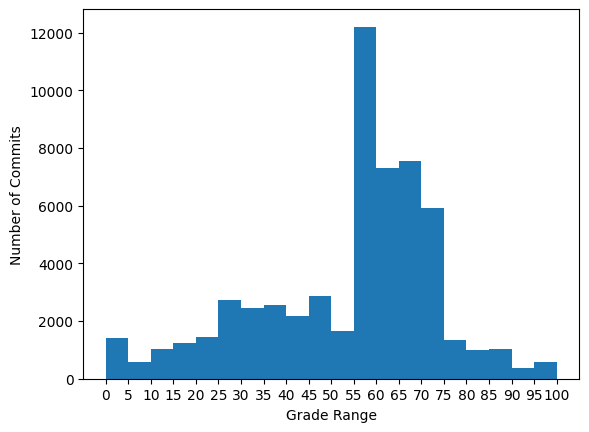

In [4]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [5]:
#test to make sure gpu is detected and save as bool
gpu_detected = tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-10-21 17:21:46.398814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2023-10-21 17:21:46.399823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6


ba5f723144744db29f788391b0b1b7a24bb8214f



In [ ]:
#if (not gpu_detected):
#    print("GPU not detected, using CPU")

model = Sequential()
model.add(Embedding(tokenizer.num_words, 1024, input_length=maxLen))
model.add(layers.Conv1D(2048, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Reshape((1, 2048)))
model.add(layers.Bidirectional(LSTM(1024, return_sequences=True)))
model.add(Dropout(0.38479930887149405))
model.add(layers.Bidirectional(LSTM(512)))
model.add(layers.Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1, activation='linear'))

print(model.summary())

model.compile(loss='mean_squared_logarithmic_error', optimizer='Adam', metrics=['mse', 'mae', 'mape', 'accuracy'])

hist = model.fit(combinedDF["tokenCode"].tolist(), combinedDF["fileGrade"].tolist(), epochs=100, batch_size=32,verbose = 1)

plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now())
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#get the commit hash for the SCA-Tokenizer submodule in the SCA-Tokenizer folder
currentPath = os.getcwd()
#strip off last dir
currentPath = currentPath[:currentPath.rfind("/")]
with open(currentPath + '/.git/modules/Model-Generation/SCA-Tokenizer/', 'r') as f:
    commitHash = f.read()
with open(modelOutputPath + "/" + timestamp + "/commitHash.txt", "w") as f:
    f.write(commitHash)




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 1024)        10240000  
                                                                 
 conv1d_2 (Conv1D)           (None, 998, 2048)         6293504   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 2048)              0         
 obalMaxPooling1D)                                               
                                                                 
 reshape_2 (Reshape)         (None, 1, 2048)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 1, 2048)           25174016  
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 1, 2048)          